In [223]:
import numpy as np
from mp_api.client import MPRester
from pymatgen.core.operations import SymmOp
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.electronic_structure.plotter import BSPlotter
from pymatgen.phonon.plotter import PhononBSPlotter
from jupyter_jsmol.pymatgen import quick_view
from lmapr1492 import plot_brillouin_zone, get_plot_bs, get_plot_dos, get_plot_bs_and_dos, get_branch_wavevectors
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from scipy.misc import derivative
from pymatgen.electronic_structure.core import Spin

In [224]:
mp_key = "jkj1S0TLmQtlvQmGDoUQvq5XQzLfKlCF"
mp_id = "mp-14437"

In [225]:
with MPRester(mp_key) as m:
    prim_struc = m.get_structure_by_material_id(mp_id)
    el_bs = m.get_bandstructure_by_material_id(mp_id)
    el_dos = m.get_dos_by_material_id(mp_id)

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

In [1]:
print("Structure de bandes électroniques du matériau:")
fig_el_bs = get_plot_bs(el_bs, plot_range=[-4,7])
fig_el_bs.show()


Structure de bandes électroniques du matériau:


NameError: name 'get_plot_bs' is not defined

In [227]:
print("En comparaison avec la densité d'électrons: ")
fig_el_bs_and_dos = get_plot_bs_and_dos(el_bs, el_dos, plot_range=[-4,7])
fig_el_bs_and_dos.show()

En comparaison avec la densité d'électrons: 


le maximum des bandes de valences et le minimum des bandes de conduction ne sont pas en face l'un de l'autre (pas le même) => bande indirecte 
l'energie es tassez conséquente 

In [228]:
infos_gap = el_bs.get_band_gap() 
print("Type de la bande interdite : indirecte")
print("Energie de la bande interdite (eV): ", infos_gap.get('energy'))
print("Vecteur d'onde de transition : ", infos_gap.get('transition'))
print("On remarque que l'énergie de la bande interdite est relativement moyenne. Donc le matériau est semi-conducteur.")


Type de la bande interdite : indirecte
Energie de la bande interdite (eV):  3.6087
Vecteur d'onde de transition :  \Gamma-F
On remarque que l'énergie de la bande interdite est relativement grande. Donc le matériau conduit plutôt mal l'électricité.


pour trouver les directions de dispersion maximale et minimale pour la bande de conduction et de valence, je dois calculer la pente de chaque interval. dans mon cas il y en a neuf.En faisant un simple calcule sur le plan energie/distance, je trouve mes pentes.ensuite, avec un algorythme max/ min,je trouve les index des pentes maximales et minimales.

In [243]:
bsp = BSPlotter(el_bs)
vbm = el_bs.get_vbm()['band_index'][Spin.up][0]
cbm = el_bs.get_cbm()['band_index'][Spin.up][0]

data = bsp.bs_plot_data()
energy = data['energy']


pentevbm = []
e_finalv=[]
e_débutv = []

fin = []
début = []

pentecbm = []
e_finalc=[]
e_débutc = []
for i, d in enumerate(data['distances']):
    pentevbm.append( abs(energy['1'][i][vbm][-1] - energy['1'][i][vbm][0]) / (d[-1] - d[0]))
    e_finalv.append(energy['1'][i][vbm][-1]) 
    e_débutv.append(energy['1'][i][vbm][0])
    pentecbm.append( abs(energy['1'][i][cbm][-1] - energy['1'][i][cbm][0]) / (d[-1] - d[0]))
    e_finalc.append(energy['1'][i][cbm][-1]) 
    e_débutc.append(energy['1'][i][cbm][0])
    
    fin.append(d[-1])
    début.append(d[0]) 

indexmaxvbm = 0
indexmaxcbm = 0
indexminvbm = 0
indexmincbm = 0
pente_val_max = -500
pente_val_min = 500
pente_cond_max = -500
pente_cond_min = 500
for i in range (len(pentevbm)):
    if(pente_val_max< pentevbm[i]):
        pente_val_max = pentevbm[i]
        indexmaxvbm = i

for i in range (len(pentevbm)):
    if(pente_val_min> pentevbm[i]):
        pente_val_min = pentevbm[i]
        indexminvbm = i  

for i in range (len(pentecbm)):
    if(pente_cond_max< pentecbm[i]):
        pente_cond_max = pentecbm[i]
        indexmaxcbm  = i

for i in range (len(pentecbm)):
    if(pente_cond_min > pentecbm[i]):
        pente_cond_min  = pentecbm[i]
        indexmincbm = i  

indexv = [indexmaxvbm ,indexminvbm]
indexc =[indexmaxcbm  ,indexmincbm]


print(pente_val_max, pente_val_min,pente_cond_max,pente_cond_min)
print(indexv,indexc)

14
0.9353409745745435 0.130602927557619 3.2295161832707264 0.42546211891007163
[5, 6] [8, 1]


j'applique des flèches pour montrer mes valeurs sur le graphe. on remarque que la mobilitée électronique n'est pas très grandes, En effet , les bandes valences et conductions n'offre pas des pentes / courbes très grandes. Les électrons auront donc une moins grandes liberté. 
De plus , La courbure de la bande dans la zone du VBM est directement liée à la masse effective des électrons. Une bande peu courbée signifie une masse effective faible, et les électrons dans cette région peuvent se déplacer plus librement. Au contraire, une bande fortement courbée indique une masse effective plus grande, ce qui limite leur mobilité.Ici ,notre VBM est très petit tandis que notre pente pour la cbm est très grande. D'autres propriétées peuvent aussi être déterminées, commes deseffets de température ou optiques.

{'band_index': defaultdict(<class 'list'>, {<Spin.up: 1>: [14, 15]}), 'kpoint_index': [0, 71, 72], 'kpoint': <pymatgen.electronic_structure.bandstructure.Kpoint object at 0x7f019a075760>, 'energy': 1.332, 'projections': {<Spin.up: 1>: array([[0.    , 0.    , 0.    , 0.    ],
       [0.0019, 0.0275, 0.3508, 0.3508],
       [0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    ]])}}


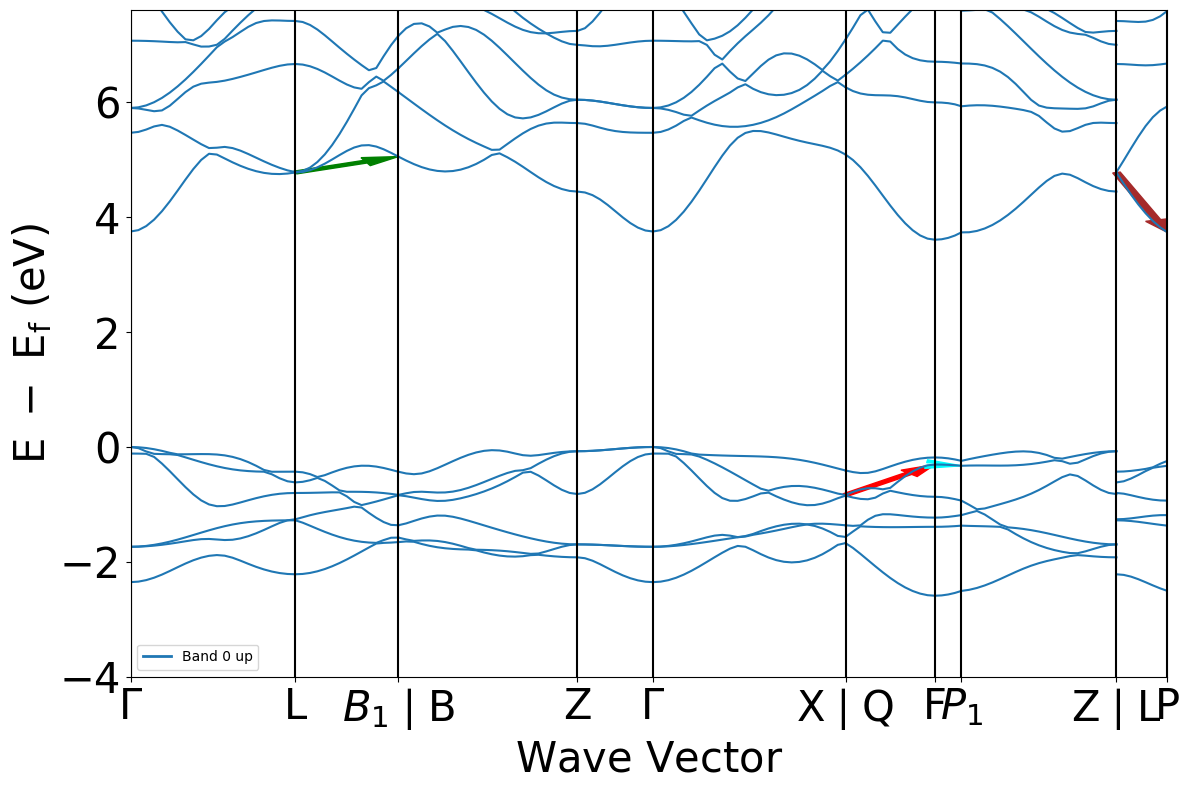

Valeur de la dispersion maximale sur la dernière bande de valence (eV) :  0.9353409745745435  sur le chemin Gamma - X.
Valeur de la dispersion minimale sur la dernière bande de valence (eV) :  0.130602927557619  sur le chemin X - W.
Valeur de la dispersion maximale sur la première bande de conduction (eV) :  3.2295161832707264  sur le chemin X - W.
Valeur de la dispersion minimale sur la première bande de conduction (eV) :  0.42546211891007163  sur le chemin L - U.


In [240]:
ccouleurs = ['brown','green']
vcouleurs = ['red','cyan']
bsp.get_plot()
fl=0
for i in indexv:
    plt.arrow(début[i], e_débutv[i], fin[i] - début[i], e_finalv[i] - e_débutv[i],color=vcouleurs[fl], width=0.05, length_includes_head=True)         
    fl +=1
fl = 0
for i in indexc:
    plt.arrow(début[i], e_débutc[i], fin[i] - début[i], e_finalc[i] - e_débutc[i],color=ccouleurs[fl], width=0.05, length_includes_head=True)         
    fl+=1
plt.show()
print("Valeur de la dispersion maximale sur la dernière bande de valence (eV) : ", pente_val_max, " sur le chemin X|Q - F.")
print("Valeur de la dispersion minimale sur la dernière bande de valence (eV) : ",pente_val_min ," sur le chemin F - P1.")
print("Valeur de la dispersion maximale sur la première bande de conduction (eV) : ", pente_cond_max, " sur le chemin Z - LP.")
print("Valeur de la dispersion minimale sur la première bande de conduction (eV) : ", pente_cond_min, " sur le chemin L - B1|B.")


je cherche maintenant ma masse effective. En toute généralité, la masse effective est définie par le tenseur
d'ordre 2 des dérivées secondes de l’énergie E par rapport au
vecteur d’onde k: m*ij = (∂²E/∂ki∂kj )−1
et E(k) -E_0 = +- h_bar²*(k²_x +k²_y+k²_z )/2*m*
. a étant la constante de la maille en angströms
G représente un vecteur de la maille réciproque. 
sa norme représente l'inverse de la distance de la maille dans l'espace réel

In [248]:

h_bar = 6.582119570e-16  
print("h_bar est en eV.s")
vbm = el_bs.get_vbm()
G = 2 * np.pi / (prim_struc.lattice.a) 
kpoint = vbm['kpoint'].frac_coords
norm = np.linalg.norm(kpoint) 
E = vbm['energy']  
masse_effective = h_bar**2 * G**2 / (2 * E)  
print(f"norme de k sur vbm : {norm}")
print(f"Masse effective de la vbm : {masse_effective} kg")


cbm = el_bs.get_cbm()
kpoint = cbm['kpoint'].frac_coords
norm = np.linalg.norm(kpoint) 
E = cbm['energy']  
masse_effective = h_bar**2 * G**2 / (2 * E)  
print(f"Norme de k sur cbm : {norm}")
print(f"Masse effective de la cbm : {masse_effective} kg")

Norme k pour le VBM : 0.0
Masse effective du VBM : 1.383521780882875e-31 kg
Norme k pour le CBM : 0.7071067811865476
Masse effective du CBM : 3.7299391020219604e-32 kg
